## Classification of presence of heart disease based on age and maximum heart rate

### Introduction

Heart disease is a prevalent issue all over the world. The data explored in this project was created at the Cleveland Clinic in Cleveland, Ohio, to build a model to estimate probablities of angiographic coronary disease and was tested with data from Hungary, Switzerland and Long Beach, California. Out of the 76 variables initially recorded for the 303 patients which were undergoing angiography in this dataset, only 14 were selected to predict the probability of coronary disease. 

With this data the aim of the project is to create a predictive model which classifies the presence or absence of heart disease based on age and maximum heart rate achieved. 

### Preliminary exploratory data analysis

In [53]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source('tests.R')
source("cleanup.R")


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [121]:
temp <- tempfile()

download.file("https://archive.ics.uci.edu/static/public/45/heart+disease.zip", temp)

processed_clev <- unzip(temp, "processed.cleveland.data")

cleveland_data <- read_csv(processed_clev, col_names = FALSE)

unlink(temp)

cleveland_data <- cleveland_data |>
             rename(
                    age = X1,
                    sex = X2,
                    cp = X3,
                    trest_bps = X4,
                    chol = X5,
                    fbs = X6,
                    rest_ecg = X7,
                    max_hr = X8,
                    ex_ang = X9,
                    old_peak = X10,
                    slope = X11,
                    ca = X12,
                    thal = X13,
                    heart_disease = X14)

integers <- c("age", "trest_bps", "chol", "max_hr", "ca")
factor <- c("sex", "cp", "fbs", "rest_ecg", "ex_ang", "slope", "thal", "heart_disease")
cleveland_data <- cleveland_data |>
            mutate(across(integers, as.integer))|>
            mutate(across(factor, as.factor)) |>
            mutate(heart_disease = fct_recode(heart_disease, "yes" = "1", "yes" = "2", "yes" = "3", 
                                              "yes" = "4", "no" = "0")) |>
            mutate(sex = fct_recode(sex, "male" = "1", "female" = "0"))|>
            mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0"))|>
            mutate(ex_ang = fct_recode(ex_ang, "yes" = "1", "no" = "0")) |>
            mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
            mutate(cp = fct_recode(cp, "typical" = "1", "atypical" = "2", "non-anginal" = "3", "asymp" = "4"))|>
            mutate(rest_ecg = fct_recode(rest_ecg, "normal" = "0", "abnormal" = "1", "hypertrophy" = "2"))|>
            mutate(thal = fct_recode(thal, "normal" = "3.0", "fixed" = "6.0", "reversable" = "7.0"))
    
            


cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(integers, as.integer)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,cp,trest_bps,chol,fbs,rest_ecg,max_hr,ex_ang,old_peak,slope,ca,thal,heart_disease
<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
63,male,typical,145,233,true,hypertrophy,150,no,2.3,downsloping,0,fixed,no
67,male,asymp,160,286,false,hypertrophy,108,yes,1.5,flat,3,normal,yes
67,male,asymp,120,229,false,hypertrophy,129,yes,2.6,flat,2,reversable,yes
37,male,non-anginal,130,250,false,normal,187,no,3.5,downsloping,0,normal,no
41,female,atypical,130,204,false,hypertrophy,172,no,1.4,upsloping,0,normal,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,male,typical,110,264,false,normal,132,no,1.2,flat,0,reversable,yes
68,male,asymp,144,193,true,normal,141,no,3.4,flat,2,reversable,yes
57,male,asymp,130,131,false,normal,115,yes,1.2,flat,1,reversable,yes


In [122]:
set.seed(3884)

clev_split <- initial_split(cleveland_data, prop = 0.75, strata = heart_disease)
clev_training <- training(clev_split)
clev_testing <- testing(clev_split)

In [123]:
clev_view <- clev_training |>
    select(heart_disease, max_hr, age) |>
    group_by(heart_disease) |>
    summarize(count = n(), mean_max_hr = mean(max_hr), mean_age = mean(age)) 
clev_view

heart_disease,count,mean_max_hr,mean_age
<fct>,<int>,<dbl>,<dbl>
no,123,159.2683,52.17073
yes,104,138.4327,57.38462


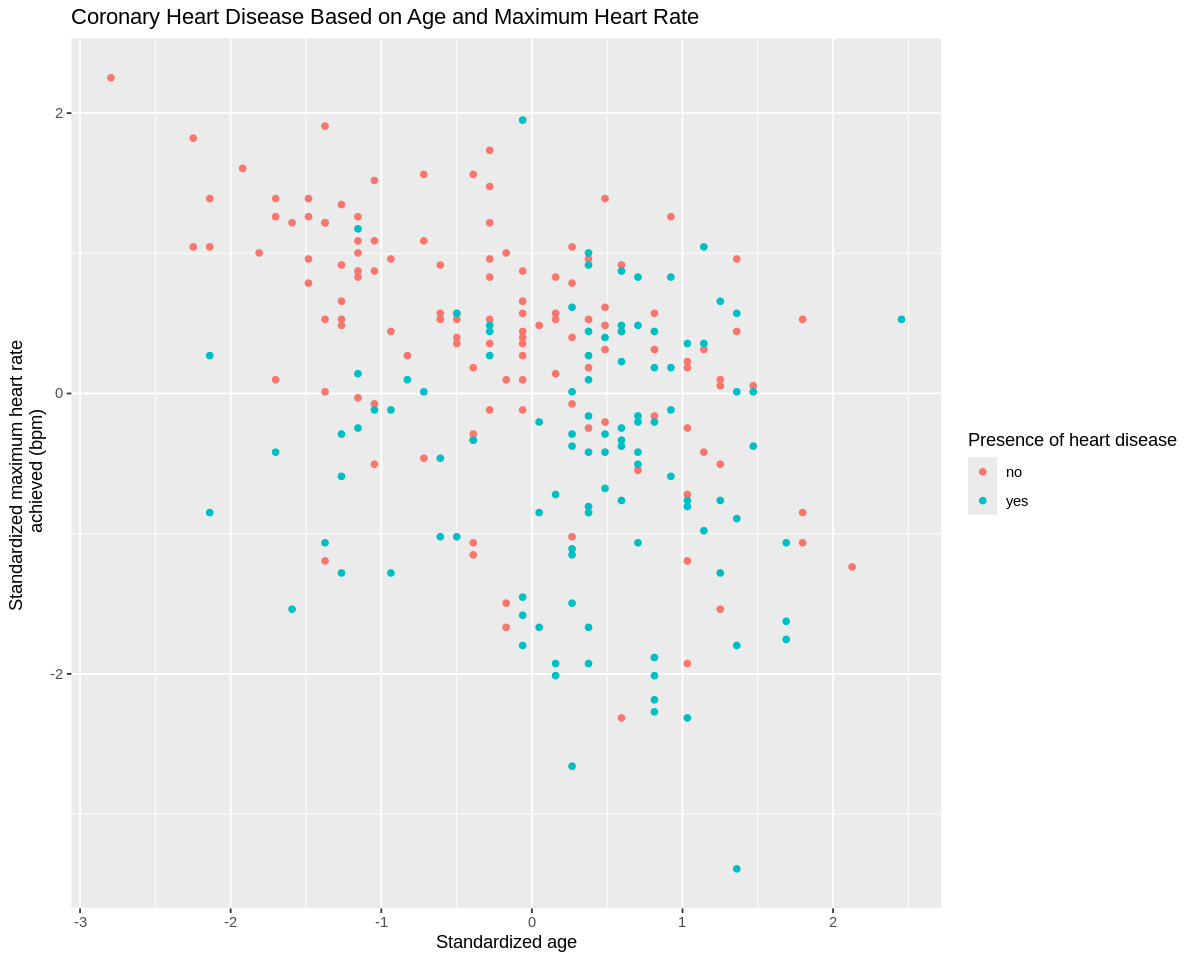

In [124]:
clev_recipe <- recipe(heart_disease ~ age + max_hr, data = clev_training)|>
      step_scale(all_predictors())|>
      step_center(all_predictors())|>
      prep()

scaled_clev <- bake(clev_recipe, clev_training)

clev_plot <- scaled_clev|>
    ggplot(aes(y = max_hr, x = age, colour = heart_disease)) +
    geom_point() +
    labs(x = "Standardized age", y = "Standardized maximum heart rate \n achieved (bpm)", 
         color = "Presence of heart disease") +
    ggtitle("Coronary Heart Disease Based on Age and Maximum Heart Rate")
    options(repr.plot.width=10, repr.plot.height=8)
clev_plot